## EGM implementation

Task: Optimize consumption over retirement and find optimal investment in a fairly priced annuity; investment only possible at time = 0 (age 65)

### Symbols
$c_t$: Consumption \
$w_t$: Wealth (beginning of period t) \
$a_t := w_t-c_t$: End of period wealth \
$p$: yearly payout of the annuity \
$R := 1+r$ with $r$ being the interest rate \
Wealth evolves according to $w_t = R * a_{t-1} + p$ \
$\sigma(w_t) = c_t^{*}$: Policy function


$u(c) := \frac{c^{1-\gamma}}{1-\gamma}$: Utility function (CRRA) \
$\gamma$ is the risk aversion parameter

Value function V:

$$V(w) := max \sum_{t=s}^{T} (\prod_{y=s}^{t}S(y)) \beta^t u(c_t)$$
Where $S(y)$ is the probability of surviving age $y$, $s$ is the starting age and $T$ is the final period

Euler equation:
$$u'(c_t) = S(t) \beta R u'(c_{t+1})$$

Solved for c_t:
$$c_t = (u')^{-1} [S(t) \beta R u'(\sigma(a_t + p))]$$

### Imports / Utility

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from interpolation import interp

In [2]:
# This is a temporary workaround; I copied the survival probabilities from https://www.ssa.gov/oact/STATS/table4c6.html
def get_s_prob(s, T):
    l = np.array([0.993919, 0.999575, 0.99974, 0.999806, 0.999846, 0.999858, 0.999865, 0.999873, 0.999884, 0.999896, 0.999903, 0.999894, 0.999856, 0.99978, 0.999677, 0.999563, 0.999448, 0.999325, 0.999194, 0.999061, 0.998921, 0.998785, 0.998673, 0.998594, 0.998539, 0.998493, 0.998443, 0.99839, 0.998332, 0.998268, 0.998205, 0.998142, 0.998077, 0.998008,
 0.997936, 0.997855, 0.997769, 0.997684, 0.997602, 0.997518, 0.99742, 0.997303, 0.997172, 0.997024, 0.996854, 0.99666, 0.996433, 0.996167, 0.995857, 0.995501,
 0.99511, 0.994679, 0.99419, 0.993637, 0.993027, 0.992371, 0.991678, 0.990951, 0.990194, 0.989405, 0.988548, 0.987642, 0.986745, 0.985874, 0.984994, 0.983999,
 0.982876, 0.981702, 0.980481, 0.979153, 0.977619, 0.975815, 0.973734, 0.97134, 0.968599, 0.965382, 0.961737, 0.95781, 0.953633, 0.949052, 0.943763,
 0.93764, 0.930774, 0.923116, 0.914548, 0.904938, 0.894171, 0.882162, 0.868862, 0.854249, 0.838322, 0.821095, 0.802592, 0.782851, 0.7619199999999999, 0.741179,
 0.721034, 0.701908, 0.684238, 0.66845, 0.651872, 0.634466, 0.616189, 0.5969990000000001, 0.576849, 0.5556909999999999, 0.5334760000000001, 0.510149,
 0.485657, 0.45994, 0.432937, 0.404583, 0.37481299999999995, 0.343553, 0.310731, 0.27626799999999996,
 0.240081, 0.20208499999999996, 0.16218900000000003, 0.12029900000000004])
    return l[s:T]

def get_annuity_payment(annuity_investment, S, R):
    accumulated_p_surv = 1
    res = 0
    for t in range(len(S)):
        accumulated_p_surv *= S[t]
        res += accumulated_p_surv / R ** t
    return annuity_investment / res

### Define Model

In [3]:
class Model:
    def __init__(self,
                 endowment=100,
                 beta=0.96,
                 gamma=5,
                 s=65,
                 T=100,
                 r=0.02,
                 annuity_investment=0,
                 consider_survival_prob=True,  # If set to false, S(t)=1 for all t
                 grid_min=1e-10,
                 grid_max=100,
                 grid_size=101
                ):
        assert endowment >= annuity_investment, "Endowment needs to be >= annuity_investment"
        self.endowment, self.beta, self.gamma, self.s, self.T = endowment, beta, gamma, s, T
        self.annuity_investment = annuity_investment
        self.n = T-s
        self.R = 1 + r
        self.grid = np.linspace(grid_min, grid_max, grid_size)
        if consider_survival_prob:
            self.S = get_s_prob(s, T)
        else:
            self.S = np.full(self.n, 1)
        self.p = get_annuity_payment(annuity_investment, self.S, self.R)

    def __repr__(self):
        return f"Model with parameters: endowment={self.endowment}, annuity investment={self.annuity_investment}, beta={self.beta}, gamma={self.gamma}, s={self.s}, T={self.T}, r={self.R}, p={self.p}"

    # Utility function
    def u(self, c):
        return c ** (1-self.gamma) / (1 - self.gamma)
    # Marginal utility
    def u_prime(self, c):
        return c ** -self.gamma
    # Inverse marginal utility
    def u_prime_inv(self, c):
        return c ** (-1 / self.gamma)

### Solve Model

In [4]:
def solve_egm(model):
    sigma = np.empty([model.n, len(model.grid)])
    sigma[-1] = model.grid # Consume everything

    # Backward induction
    for t in reversed(range(model.n - 1)):
        w_temp = np.empty(len(model.grid))
        sigma_temp = np.empty(len(model.grid))
        sigma_next = lambda w: interp(model.grid, sigma[t+1], w)

        for i, a in enumerate(model.grid):
            sigma_temp[i] = model.u_prime_inv(model.S[t] * model.beta * model.R * model.u_prime(sigma_next(a + model.p)))
            w_temp[i] = sigma_temp[i] + a

        # Interpolate results back to common grid
        for i, w in enumerate(model.grid):
            # Set upper limit of c <= w
            sigma[t, i] = min(interp(w_temp, sigma_temp, w), w)
    return sigma

###  Simulate Lifecycle

In [5]:
def simulate_lifecycle(sigma_grid, m):
    a_grid = np.empty(m.n)
    w_grid = np.empty(m.n)
    c_grid = np.empty(m.n)
    # Value
    v = 0

    surv_prob_accumulated = 1

    for t in range(m.n):
        sigma = lambda w: interp(m.grid, sigma_grid[t], w)
        if t == 0:
            w_grid[0] = m.endowment - m.annuity_investment + m.p
            c_grid[0] = sigma(w_grid[0])
            a_grid[0] = w_grid[0] - c_grid[0]
            v = m.u(c_grid[0])
        else:
            w_grid[t] = m.R * a_grid[t-1] + m.p
            c_grid[t] = sigma(w_grid[t])
            a_grid[t] = w_grid[t] - c_grid[t]
            v += m.beta ** t * surv_prob_accumulated * m.u(c_grid[t])
        surv_prob_accumulated *= m.S[t]

    return w_grid, c_grid, v

### Function for Plotting Results

In [6]:
def plot_policy_function(sigma, model):
    fig, ax = plt.subplots()
    ax.set_title("Policy function")
    ax.set_xlabel("wealth")
    ax.set_ylabel("consumption")
    for i in range(len(sigma)):
        if i % 5 == 0 or i == len(sigma) - 1:
            ax.plot(model.grid, sigma[i], color=plt.cm.jet(i / len(sigma)), lw=2, alpha=0.6, label=f"t={i}")
        else:
            ax.plot(model.grid, sigma[i], color=plt.cm.jet(i / len(sigma)), lw=2, alpha=0.6)
    ax.legend()

def plot_lifecycle(w_grid, c_grid, m):
    fig, ax = plt.subplots()
    ax.set_title("Simulated consumption / wealth development")
    ax.set_xlabel("Time")
    ax.set_ylabel("wealth / consumption")
    ax.plot(range(m.n), w_grid, color="red", lw=2, alpha=0.6, label="wealth")
    ax.plot(range(m.n), c_grid, color="blue", lw=2, alpha=0.6, label="consumption")
    ax.legend()

### Find optimal annuity investment

In [7]:
# Calculate expected value for different annuity investments
for i in range(11):
    m = Model(endowment=100, annuity_investment=10 * i)
    sigma_grid = solve_egm(m)
    v = simulate_lifecycle(sigma_grid, m)[2]
    print(f"For annuity investment {10*i}, expected value is {v}")

For annuity investment 0, expected value is -0.013192839335507526
For annuity investment 10, expected value is -0.00883124611915338
For annuity investment 20, expected value is -0.006224773863534459
For annuity investment 30, expected value is -0.004575173934556673
For annuity investment 40, expected value is -0.0034964948837243794
For annuity investment 50, expected value is -0.00276829176334972
For annuity investment 60, expected value is -0.002256198079421963
For annuity investment 70, expected value is -0.0018903754468383163
For annuity investment 80, expected value is -0.0016349404225112728
For annuity investment 90, expected value is -0.0014558224712085883
For annuity investment 100, expected value is -0.0013659808007620866


### Plot graphs for annuity investment = 0

Model with parameters: endowment=100, annuity investment=0, beta=0.96, gamma=5, s=65, T=100, r=1.02, p=0.0


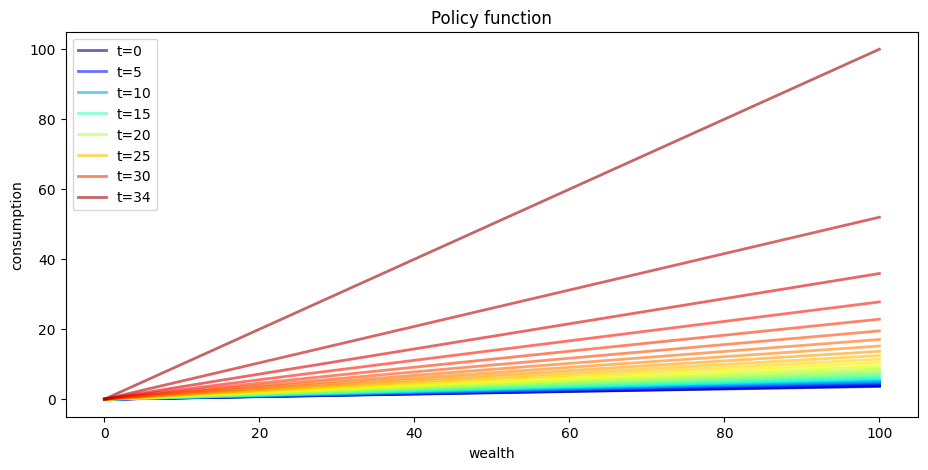

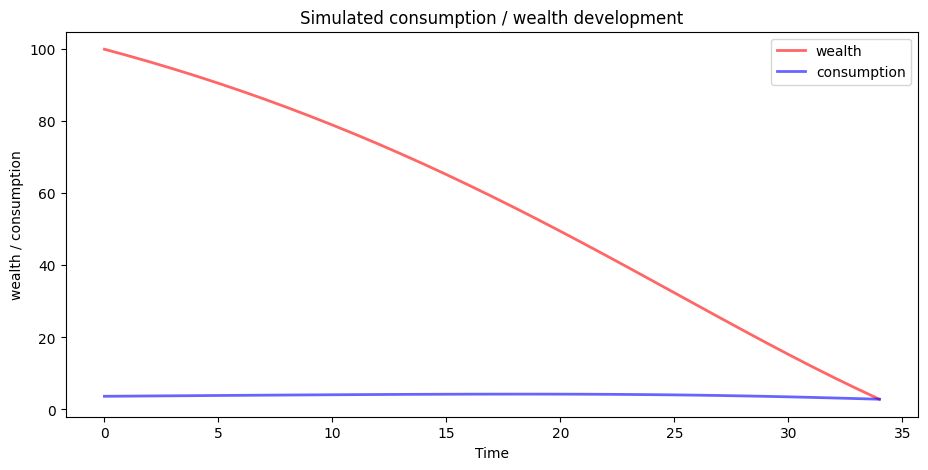

In [8]:
m = Model()
print(m)
sigma = solve_egm(m)
plot_policy_function(sigma,m)
w_grid, c_grid, v = simulate_lifecycle(sigma, m)
plot_lifecycle(w_grid, c_grid, m)

### Plot graphs for annuity investment = 100

Model with parameters: endowment=100, annuity investment=100, beta=0.96, gamma=5, s=65, T=100, r=1.02, p=6.920266059438831


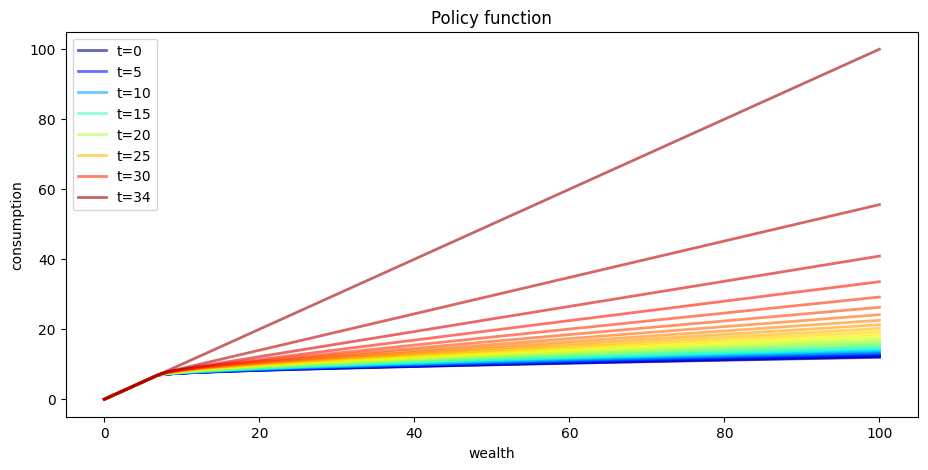

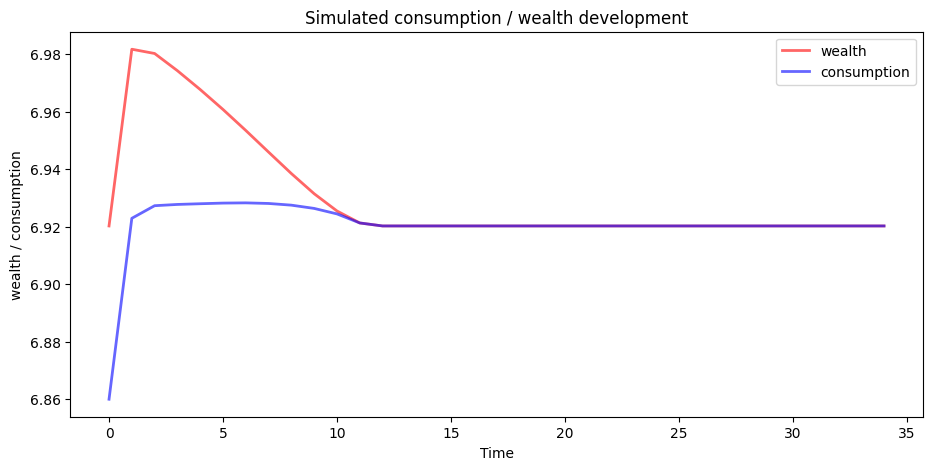

In [9]:
m = Model(annuity_investment=100)
print(m)
sigma = solve_egm(m)
plot_policy_function(sigma,m)
w_grid, c_grid, v = simulate_lifecycle(sigma, m)
plot_lifecycle(w_grid, c_grid, m)